In [1]:
import os
import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output
from icecream import ic
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')


### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment).
[Transformers library doc](https://huggingface.co/transformers/)


## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):

### Importing the dataset

In [2]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
print(df.shape)
df.head()

(6920, 2)


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


### Using BERT for text classification.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Loading a pretrained model
# For DistilBERT, Load pretrained model/tokenizer:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)

In [4]:
# recursive function to display model_structure
def model_structure(layer, margin=0):
    for name, next_layer in layer.named_children():
        next = list(next_layer.named_children()) != []
        print(' ' * margin + name + ':' * next)
        model_structure(next_layer, margin + len(name) + 1)

model_structure(model)

embeddings:
           word_embeddings
           position_embeddings
           LayerNorm
           dropout
transformer:
            layer:
                  0:
                    dropout
                    attention:
                              dropout
                              q_lin
                              k_lin
                              v_lin
                              out_lin
                    sa_layer_norm
                    ffn:
                        dropout
                        lin1
                        lin2
                    output_layer_norm
                  1:
                    dropout
                    attention:
                              dropout
                              q_lin
                              k_lin
                              v_lin
                              out_lin
                    sa_layer_norm
                    ffn:
                        dropout
                        lin1
                       

### Preparing the dataset

In [5]:
# Tokenization example
print(df[0][1])
tokenizer.encode(df[0][1], return_tensors='pt')

apparently reassembled from the cutting room floor of any given daytime soap


tensor([[ 4593,  2128, 27241, 23931,  2013,  1996,  6276,  2282,  2723,  1997,
          2151,  2445, 12217,  7815]])

In [38]:
from data_preporation import  collate_fn, ReviewsSampler, ReviewsDataset

params = dict(
    train_size=0.8,
    val_size=0.1,
    seed=0xDEAD,
    batch=32,
    hidden=256,
    do=0.5,
    lr=3e-5,
    epochs=40,
    clip=1,
    save_fname='best_bert_sentiment.pt',
)

# dataset contains train/test/vat
dataset = ReviewsDataset(df[0], tokenizer, df[1])

torch.manual_seed(params['seed'])
train_size, val_size = int(params['train_size'] * len(dataset)), int(params['val_size'] * len(dataset))
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

# train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data, params['batch']), collate_fn=collate_fn)
# valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data, params['batch']), collate_fn=collate_fn)
# test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data, params['batch']), collate_fn=collate_fn)
train_loader = DataLoader(train_data, batch_size=params['batch'], collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=params['batch'], collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=params['batch'], collate_fn=collate_fn)

Number of training examples: 5536
Number of validation examples: 692
Number of testing examples: 692


### Baseline (training from scratch)

In [78]:
class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, hidden_size, dropout):
        super().__init__()
        self.bert = pretrained_model

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.ln1 = nn.LazyBatchNorm1d()
        self.fc = nn.LazyLinear(hidden_size)
        self.ln2 = nn.LazyBatchNorm1d()
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, inputs, attention_mask):
        # [batch_size, seq_len]

        hidden_states = self.bert(inputs, attention_mask=attention_mask)[0]
        # [batch_size, seq_len, bert_hidden_size]

        # can do mean
        hidden_states = hidden_states.mean(dim=1)

        # or can extract first hidden state
        # hidden_states = hidden_states[:, 0, :]
        # [batch_size, bert_hidden_size]

        hidden_states = self.fc(self.dropout(self.relu(self.ln1(hidden_states))))
        outputs = self.fc_out(self.ln2(hidden_states))
        # [batch_size, 1]

        # proba = [batch_size, ] - probability to be positive
        return self.sigmoid(outputs)


def extract_batch(batch):
    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)
    mask = batch['attention_mask'].to(device)
    return inputs, labels, mask


def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    pred_labels, true_labels = [], []

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        inputs, labels, mask = extract_batch(batch)
        output = model(inputs, mask).squeeze()
        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        pred_labels.append(output.detach().cpu().numpy() >= 1/2)
        true_labels.append(labels.cpu().numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    pred_labels = np.concatenate(pred_labels, axis=0)
    return epoch_loss / (i + 1), accuracy_score(true_labels, pred_labels)


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    pred_labels, true_labels = [], []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            inputs, labels, mask = extract_batch(batch)
            output = model(inputs, mask).squeeze()
            loss = criterion(output, labels)
            epoch_loss += loss.item()
            pred_labels.append(output.cpu().numpy() >= 1/2)
            true_labels.append(labels.cpu().numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    pred_labels = np.concatenate(pred_labels, axis=0)
    return epoch_loss / (i + 1), accuracy_score(true_labels, pred_labels)

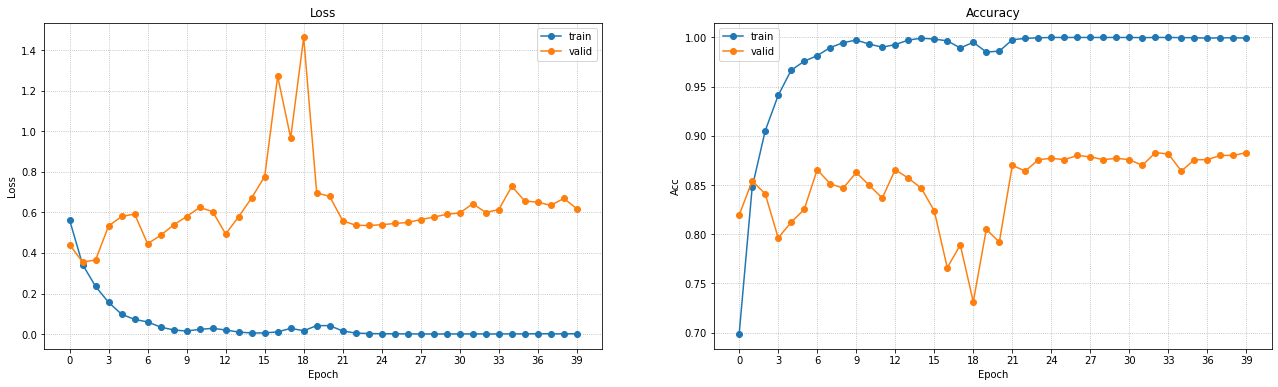

In [88]:
model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model, hidden_size=params['hidden'], dropout=params['do']).to(device)
optimizer = optim.Adam(bert_clf.parameters(), lr=params['lr'])
criterion = nn.BCELoss()

train_loss_hist, valid_loss_hist = [], []
train_acc_hist, valid_acc_hist = [], []
best_valid_loss = float('inf')
best_valid_acc = 0

if os.path.isfile(params['save_fname']):
    os.remove(params['save_fname'])

for epoch in range(params['epochs']):
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, params['clip'])
    valid_loss, val_acc = evaluate(bert_clf, valid_loader, criterion)

    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(bert_clf.state_dict(), 'acc_' + params['save_fname'])

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'loss_' + params['save_fname'])


    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)

    train_acc_hist.append(train_acc)
    valid_acc_hist.append(val_acc)

    # display/update the results
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))
    clear_output(True)
    axes[0].set_title('Loss')
    axes[0].set_ylabel('Loss')
    axes[0].plot(train_loss_hist, label='train', marker='o')
    axes[0].plot(valid_loss_hist, label='valid', marker='o')

    axes[1].set_title('Accuracy')
    axes[1].set_ylabel('Acc')
    axes[1].plot(train_acc_hist, label='train', marker='o')
    axes[1].plot(valid_acc_hist, label='valid', marker='o')

    for ax in axes:
        # if more than 20 epochs display only each 3rd epoch
        ticks = [i  for i in range(0, len(train_acc_hist), 2 + (len(train_acc_hist) > 20))]
        ax.set_xticks(ticks)
        ax.set_xlabel('Epoch')
        ax.grid(True, linestyle=':')
        ax.legend()

    plt.show()

In [90]:
best_model = BertClassifier(model, params['hidden'], params['do']).to(device)
best_model.load_state_dict(torch.load('acc_' + params['save_fname']))

_, test_acc = evaluate(best_model, test_loader, criterion)
print(test_acc)
assert test_acc >= 0.86

0.8872832369942196
